In [1]:
# CAP 5610 Project
# Dataset Link: https://www.kaggle.com/c/ieee-fraud-detection
# Feature Engineering: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575
# https://www.kaggle.com/kenjee/titanic-project-example 
# evaluation metrics: https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os

train_identity = pd.read_csv(os.getcwd() + "\\train_identity.csv")
train_transaction = pd.read_csv(os.getcwd() + "\\train_transaction.csv")

# print(train_identity.head())
# print(train_transaction.head())

'''

We are predicting whether a given transaction is considered fraud or not, as indicated by the isFraud column
in train_transaction.

Not all transactions have corresponding identity information.


General information about the meaning of the data features from the competition discussion:

Transaction Table *
TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
TransactionAMT: transaction payment amount in USD
ProductCD: product code, the product for each transaction
card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
addr: address
dist: distance
P_ and (R__) emaildomain: purchaser and recipient email domain
C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
D1-D15: timedelta, such as days between previous transaction, etc.
M1-M9: match, such as names on card and address, etc.
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
Categorical Features:
ProductCD
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9

Identity Table *
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
DeviceType
DeviceInfo
id_12 - id_38

'''


"\n\nWe are predicting whether a given transaction is considered fraud or not, as indicated by the isFraud column\nin train_transaction.\n\nNot all transactions have corresponding identity information.\n\n\nGeneral information about the meaning of the data features from the competition discussion:\n\nTransaction Table *\nTransactionDT: timedelta from a given reference datetime (not an actual timestamp)\nTransactionAMT: transaction payment amount in USD\nProductCD: product code, the product for each transaction\ncard1 - card6: payment card information, such as card type, card category, issue bank, country, etc.\naddr: address\ndist: distance\nP_ and (R__) emaildomain: purchaser and recipient email domain\nC1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.\nD1-D15: timedelta, such as days between previous transaction, etc.\nM1-M9: match, such as names on card and address, etc.\nVxxx: Vesta engineered rich feat

In [2]:
train_identity.info()

'''

All columns in train_identity seem like categorical data. More specifically, they are nominal. However, the description 
provided of the features in train_identity states that DeviceType, DeviceInfo, and id_12 - id_38 are the only features 
that are categorical. Will inspect id_01-id_11 to confirm their type.

'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

'\n\nAll columns in train_identity seem like categorical data. More specifically, they are nominal. However, the description \nprovided of the features in train_identity states that DeviceType, DeviceInfo, and id_12 - id_38 are the only features \nthat are categorical. Will inspect id_01-id_11 to confirm their type.\n\n'

In [3]:
train_transaction.info()
'''

train_transaction contains a mix of categorical and numeric data. 

'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


'\n\ntrain_transaction contains a mix of categorical and numeric data. \n\n'

In [2]:
# Data Preprocessing

# replace null values with -999
train_identity = train_identity.fillna(value = -999)
train_transaction = train_transaction.fillna(value = -999)

from sklearn import preprocessing

# convert non-numeric columns to numeric by assigning each class to a number
number = preprocessing.LabelEncoder()

for col in list(train_identity):
    if (train_identity[col].dtype == "object"):
        train_identity[col] = train_identity[col].astype(str)
        train_identity[col] = number.fit_transform(train_identity[col])
        
for col in list(train_transaction):
    if (train_transaction[col].dtype == "object"):
        train_transaction[col] = train_transaction[col].astype(str)
        train_transaction[col] = number.fit_transform(train_transaction[col])
        

In [3]:
# not all transactions have corresponding identity data, so only include those with identity data
# df = pd.merge(train_identity, train_transaction, on = "TransactionID", how = "left")

# not all transactions have corresponding identity data, so for instances with no corresponding idenity data, fill with 
# dummy values
df = pd.merge(train_identity, train_transaction, on = "TransactionID", how = "outer")
df = df.fillna(value = -999)

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(["isFraud"], axis = 1).values

y = df["isFraud"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25, stratify = y)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y, random_state = 0, test_size = 50, train_size = 50, stratify = y)

print(X_train_small.shape)

(50, 433)


In [8]:
def metrics(model, X_test):
    predicted = model.predict(X_test)

    from sklearn.metrics import accuracy_score

    print("The accuracy score is " + str(accuracy_score(y_test, predicted)))

    from sklearn.metrics import confusion_matrix

    print("Confusion matrix: ")
    print(confusion_matrix(y_test, predicted))

    from sklearn.metrics import precision_score

    print("The precision score is " + str(precision_score(y_test, predicted)))

    from sklearn.metrics import recall_score

    print("The recall score is " + str(recall_score(y_test, predicted)))


    from sklearn.metrics import f1_score

    print("The F1 score is " + str(f1_score(y_test, predicted)))

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion = "entropy")
model.fit(X_train, y_train)

metrics(model, X_test)

The accuracy score is 0.9795712398821418
Confusion matrix: 
[[142294    131]
 [  2885   2325]]
The precision score is 0.9466612377850163
The recall score is 0.44625719769673705
The F1 score is 0.6065744847378033


In [7]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)

metrics(model, X_test)

The accuracy score is 0.9711586006028381
Confusion matrix: 
[[142040    385]
 [  3873   1337]]
The precision score is 0.7764227642276422
The recall score is 0.2566218809980806
The F1 score is 0.3857472590882861


In [8]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

metrics(model, X_test)

The accuracy score is 0.9647102651810208
Confusion matrix: 
[[142425      0]
 [  5210      0]]
The precision score is 0.0
The recall score is 0.0
The F1 score is 0.0


C:\Users\Dillan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


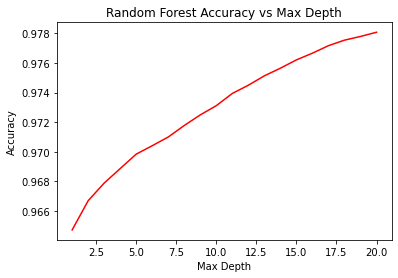

Best Depth: 20
Best Depth Accuracy 0.9780810783350832


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

vars = []
for i in range(20):
    model = RandomForestClassifier(criterion = "entropy", max_depth=i+1)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    vars.append(accuracy_score(y_test, predicted))
    
plt.title("Random Forest Accuracy vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.plot(np.arange(1,21), vars, color ="red")
plt.show()
print("Best Depth: " + str(vars.index(max(vars)) + 1))
print("Best Depth Accuracy " + str(max(vars)))
    

ValueError: x and y must have same first dimension, but have shapes (20,) and (19,)

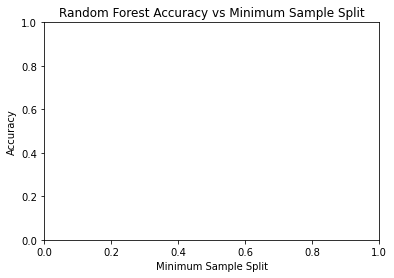

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

vars = []
for i in range(1000, 20000, 1000):
    model = RandomForestClassifier(criterion = "entropy", max_depth=10, min_samples_split=i)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    vars.append(accuracy_score(y_test, predicted))
    
plt.title("Random Forest Accuracy vs Minimum Sample Split")
plt.xlabel("Minimum Sample Split")
plt.ylabel("Accuracy")
plt.plot(np.arange(1000, 20001, 1000), vars, color ="red")
plt.show()
print("Best Minimum Sample Split: " + str(vars.index(max(vars)) + 1))
print("Best Minimum Sample Split Accuracy " + str(max(vars)))

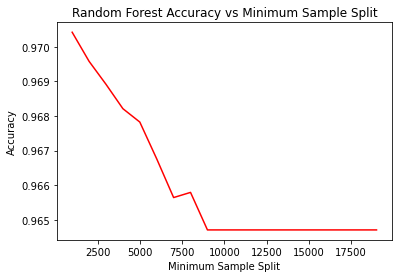

Best Minimum Sample Split: 1000
Best Minimum Sample Split Accuracy 0.9704202932908863


In [16]:
plt.title("Random Forest Accuracy vs Minimum Sample Split")
plt.xlabel("Minimum Sample Split")
plt.ylabel("Accuracy")
plt.plot(np.arange(1000, 20000, 1000), vars, color ="red")
plt.show()
print("Best Minimum Sample Split: " + str(vars.index(max(vars)) + 1) + "000")
print("Best Minimum Sample Split Accuracy " + str(max(vars)))

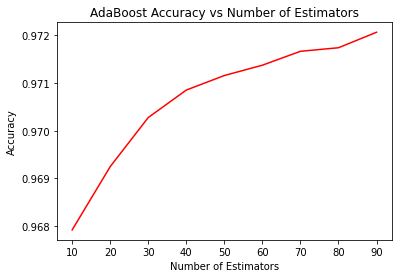

Best Number of Estimators: 90
Best Number of Estimators Accuracy 0.9720662444542283


In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

vars = []
for i in range(10, 100, 10):
    model = AdaBoostClassifier(n_estimators=i)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    vars.append(accuracy_score(y_test, predicted))
    
plt.title("AdaBoost Accuracy vs Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.plot(np.arange(10, 100, 10), vars, color ="red")
plt.show()
print("Best Number of Estimators: " + str(vars.index(max(vars)) + 1) + "0")
print("Best Number of Estimators Accuracy " + str(max(vars)))
    

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

linear_support_vector_machine = SVC(kernel='linear')
cv_score = cross_val_score(linear_support_vector_machine, X_train_small, y_train_small, cv=2)
print("Average Classification Accuracy for Linear SVM: %f" % cv_score.mean())

quad_support_vector_machine = SVC(kernel='poly', degree=2, gamma='auto')
cv_score = cross_val_score(quad_support_vector_machine, X_train_small, y_train_small, cv=2)
print("Average Classification Accuracy for quadratic SVM: %f" % cv_score.mean())

rbf_support_vector_machine = SVC(kernel='rbf', gamma='auto')
cv_score = cross_val_score(rbf_support_vector_machine, X_train_small, y_train_small, cv=2)
print("Average Classification Accuracy for RBF SVM: %f" % cv_score.mean())

# note that SVC was tested on a small sample(50) due to longer runtimes, thus it may not be feasible to use this model

Average Classification Accuracy for Linear SVM: 0.940000
Average Classification Accuracy for quadratic SVM: 0.920000
Average Classification Accuracy for RBF SVM: 0.960000


In [9]:
# since random forest performed the best, we will be using this model with the best hyperparameters that could intuitively
# be determined

# Scale the data
scaled_features = train_transaction.copy()

unscaled_col_names = ["isFraud", "TransactionID", "card1", "card2", "card3", "card4", "card5", "card6", "ProductCD", "addr1", "addr2", "P_emaildomain", "R_emaildomain", "M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"]
col_names = train_transaction.drop(unscaled_col_names, axis = 1).columns

scaler = preprocessing.StandardScaler().fit(train_transaction[col_names].values)
train_transaction[col_names] = scaler.transform(train_transaction[col_names].values)
print(train_transaction.head)

df = pd.merge(train_identity, train_transaction, on = "TransactionID", how = "outer")
df = df.fillna(value = -999)

from sklearn.model_selection import train_test_split

X = df.drop(["isFraud"], axis = 1).values

y = df["isFraud"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25, stratify = y)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion = "entropy", max_depth = 20, min_samples_split=20)
model.fit(X_train, y_train)

metrics(model, X_test)

<bound method NDFrame.head of         TransactionID  isFraud  TransactionDT  TransactionAmt  ProductCD  \
0             2987000        0      -1.577987       -0.278167          4   
1             2987001        0      -1.577986       -0.443327          4   
2             2987002        0      -1.577972       -0.317889          4   
3             2987003        0      -1.577965       -0.355521          4   
4             2987004        0      -1.577964       -0.355521          1   
...               ...      ...            ...             ...        ...   
590535        3577535        0       1.827666       -0.359702          4   
590536        3577536        0       1.827666       -0.399424          4   
590537        3577537        0       1.827673       -0.435174          4   
590538        3577538        0       1.827675       -0.075376          4   
590539        3577539        0       1.827684        0.605960          4   

        card1  card2  card3  card4  card5  ...      V330 

In [10]:
# Feature Selection

# note that this is with scaled data

'''from sklearn.feature_selection import VarianceThreshold

print("df before: " + str(df.shape))
selector = VarianceThreshold()
df = pd.DataFrame(selector.fit_transform(df), columns = df.columns)
print("df after: " + str(df.shape))'''

from sklearn.feature_selection import SelectKBest, f_classif
import math

print("df before: " + str(df.shape))
selector = SelectKBest(f_classif, k=math.floor(df.shape[1] * 0.4))
selector.fit(df.drop(["isFraud"], axis = 1).values, df["isFraud"].values)
cols = selector.get_support(indices=True)
cols = np.append(cols, [df.columns.get_loc("isFraud")])
df = df.iloc[:, cols]
print("df after: " + str(df.shape))

from sklearn.model_selection import train_test_split

X = df.drop(["isFraud"], axis = 1).values

y = df["isFraud"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25, stratify = y)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion = "entropy", max_depth = 20, min_samples_split=20)
model.fit(X_train, y_train)

metrics(model, X_test)

df before: (590540, 434)
df after: (590540, 174)
The accuracy score is 0.9736038202323297
Confusion matrix: 
[[142309    160]
 [  3737   1429]]
The precision score is 0.8993077407174324
The recall score is 0.27661633759194737
The F1 score is 0.42309400444115475


K percentage: 20%
df before: (590540, 434)
df after: (590540, 86)
K percentage: 30%
df before: (590540, 434)
df after: (590540, 130)
K percentage: 40%
df before: (590540, 434)
df after: (590540, 173)
K percentage: 50%
df before: (590540, 434)
df after: (590540, 217)
K percentage: 60%
df before: (590540, 434)
df after: (590540, 260)
K percentage: 70%
df before: (590540, 434)
df after: (590540, 303)
K percentage: 80%
df before: (590540, 434)
df after: (590540, 347)
K percentage: 90%
df before: (590540, 434)
df after: (590540, 390)
K percentage: 100%
df before: (590540, 434)
df after: (590540, 434)


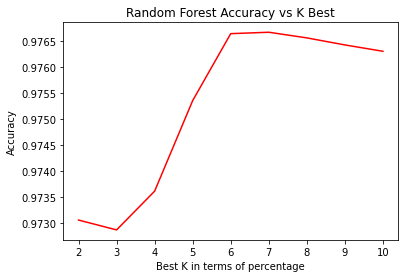

Best K: 6
Best K Accuracy 0.9766654248653774


In [13]:
from sklearn.feature_selection import SelectKBest, f_classif
import math
from sklearn.metrics import accuracy_score

df = pd.merge(train_identity, train_transaction, on = "TransactionID", how = "outer")
df = df.fillna(value = -999)

vars = []
for i in range(2, 11, 1):
    
    print("K percentage: " + str(i * 10) + "%")
    print("df before: " + str(df.shape))
    selector = SelectKBest(f_classif, k=math.floor(df.shape[1] * 0.1 * i) - 1)
    selector.fit(df.drop(["isFraud"], axis = 1).values, df["isFraud"].values)
    cols = selector.get_support(indices=True)
    cols = np.append(cols, [df.columns.get_loc("isFraud")])
    new_df = df.iloc[:, cols]
    print("df after: " + str(new_df.shape))
    
    X = new_df.drop(["isFraud"], axis = 1).values

    y = new_df["isFraud"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25, stratify = y)
    
    model = RandomForestClassifier(criterion = "entropy", max_depth = 20, min_samples_split=20)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    vars.append(accuracy_score(y_test, predicted))
    
plt.title("Random Forest Accuracy vs K Best")
plt.xlabel("Best K in terms of percentage")
plt.ylabel("Accuracy")
plt.plot(np.arange(2, 11, 1), vars, color ="red")
plt.show()
print("Best K: " + str(vars.index(max(vars)) + 1))
print("Best K Accuracy " + str(max(vars)))

In [14]:
# final best model

# assumes scaling and other data preprocessing already done to create df
from sklearn.feature_selection import SelectKBest, f_classif
import math

print("df before: " + str(df.shape))
selector = SelectKBest(f_classif, k=math.floor(df.shape[1] * 0.6))
selector.fit(df.drop(["isFraud"], axis = 1).values, df["isFraud"].values)
cols = selector.get_support(indices=True)
cols = np.append(cols, [df.columns.get_loc("isFraud")])
df = df.iloc[:, cols]
print("df after: " + str(df.shape))

from sklearn.model_selection import train_test_split

X = df.drop(["isFraud"], axis = 1).values

y = df["isFraud"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25, stratify = y)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion = "entropy", max_depth = 20, min_samples_split=20)
model.fit(X_train, y_train)

metrics(model, X_test)

df before: (590540, 434)
df after: (590540, 261)
The accuracy score is 0.9767060656348426
Confusion matrix: 
[[142327    142]
 [  3297   1869]]
The precision score is 0.929388363998011
The recall score is 0.3617886178861789
The F1 score is 0.5208304305420093
